<a href="https://colab.research.google.com/github/leokan92/class/blob/main/Aula5_autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aula 5 - Redes autoassociativas (*autoencoders*)

In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim

# Definindo a transformação para adicionar ruído
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x + 0.1*torch.randn_like(x))
])

# Carregar os dados do MNIST
train_set = datasets.MNIST(root='./data', download=True, train=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 89982342.00it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 84297629.66it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27885871.76it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14860006.84it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Definição da arquitetura da rede autoassociativa

In [2]:


# Definindo o autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3)  # Comprime para uma representação de 3 dimensões
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()  # As imagens do MNIST são em escala de cinza, então os valores devem estar entre 0 e 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x




## Treinamento da rede

In [3]:
# Instanciar o modelo
model = Autoencoder()

# Critério de perda e otimizador
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Treinamento do autoencoder
for epoch in range(5):  # Loop por 5 épocas
    for data in train_loader:
        imgs, _ = data
        imgs = imgs.view(imgs.size(0), -1)  # Achatar as imagens
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, imgs)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 0.05585645139217377
Epoch 2, Loss: 0.048297591507434845
Epoch 3, Loss: 0.049920402467250824
Epoch 4, Loss: 0.04749774560332298
Epoch 5, Loss: 0.04589812457561493


## Dataset de teste

In [5]:
# Transformação para o conjunto de teste
# Aqui não adicionamos ruído, pois queremos comparar as imagens ruidosas de entrada com as imagens originais limpas
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Carregando o conjunto de teste do MNIST
test_set = datasets.MNIST(root='./data', download=True, train=False, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)

## Testando a remoção de ruído

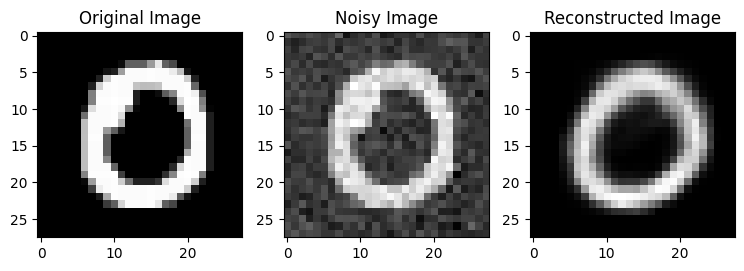

In [7]:
import matplotlib.pyplot as plt

# Supondo que você tenha um DataLoader chamado 'test_loader' para os dados de teste
dataiter = iter(test_loader)
images, labels = dataiter.__next__()

# Vamos adicionar ruído às imagens de teste também
images_noisy = images + 0.1*torch.randn_like(images)
images_noisy = images_noisy.view(images_noisy.size(0), -1)

# Selecionando uma imagem de exemplo
img_noisy = images_noisy[0]

# Passando a imagem com ruído pelo autoencoder para obter a reconstrução
img_reconstructed = model(img_noisy).detach()

# Plotando a imagem com ruído e a reconstruída
plt.figure(figsize=(9, 3))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(images[0].reshape(28, 28), cmap='gray')
plt.subplot(1, 3, 2)
plt.title("Noisy Image")
plt.imshow(img_noisy.reshape(28, 28), cmap='gray')
plt.subplot(1, 3, 3)
plt.title("Reconstructed Image")
plt.imshow(img_reconstructed.reshape(28, 28), cmap='gray')
plt.show()


## Usando rede associativa variacional para gerar imagens

Epoch: 1 Train loss: 136.3842
Epoch: 2 Train loss: 113.3481
Epoch: 3 Train loss: 110.2342
Epoch: 4 Train loss: 108.7289
Epoch: 5 Train loss: 107.8116
Epoch: 6 Train loss: 107.1323
Epoch: 7 Train loss: 106.5925
Epoch: 8 Train loss: 106.1273
Epoch: 9 Train loss: 105.7832
Epoch: 10 Train loss: 105.4774


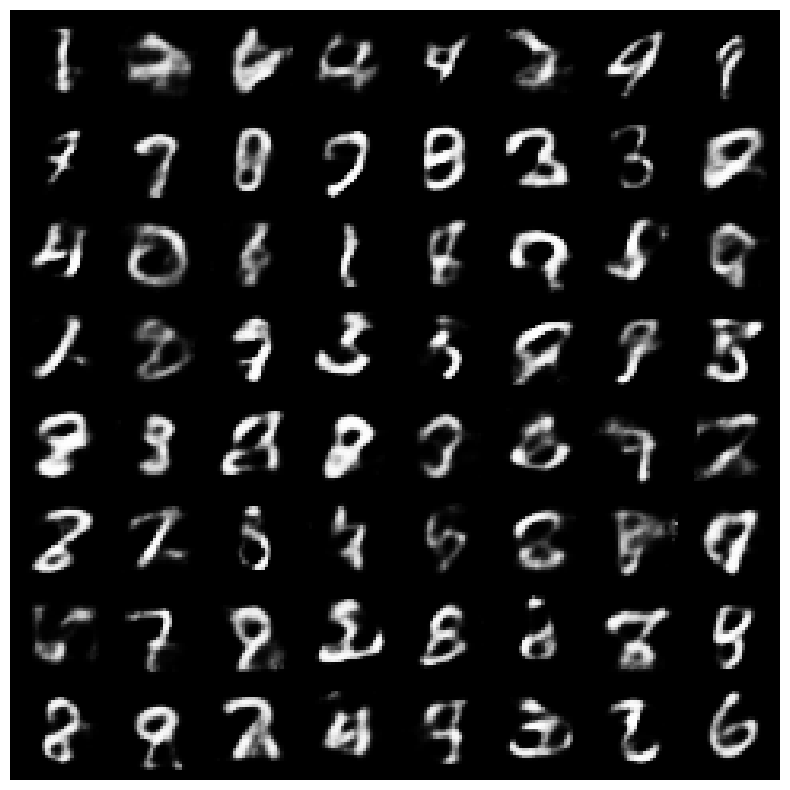

In [8]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Definição da arquitetura do VAE
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)  # média
        self.fc22 = nn.Linear(400, 20)  # log de variância
        # Decoder
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Função de perda para VAE
def loss_function(recon_x, x, mu, logvar):
    BCE = torch.nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Preparando os dados de treinamento
transform = transforms.Compose([transforms.ToTensor()])
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(mnist_trainset, batch_size=32, shuffle=True)

# Instanciando o modelo, otimizador e definindo a função de perda
vae = VAE()
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Treinamento do VAE
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print('Epoch: {} Train loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

# Executando o treinamento
for epoch in range(1, 11):  # Vamos treinar por 10 épocas
    train(epoch)

# Gerando novos dígitos
with torch.no_grad():
    sample = torch.randn(64, 20)  # 64 amostras no espaço latente de 20 dimensões
    sample = vae.decode(sample).cpu()
    # Transformando a saída para imagens
    generated = make_grid(sample.view(64, 1, 28, 28))

plt.figure(figsize=(10, 10))
plt.imshow(generated.numpy().transpose(1, 2, 0))
plt.axis('off')
plt.show()